## 7. Futures Trend Following Model
Having established a framework for measuring and filtering signals with downside-aware metrics, we now turn to the actual strategy models. The first is trend following, a cornerstone of systematic futures trading.

### 7.1. Principles of Trend Following
The mechanics are straightforward, but execution requires discipline. Most trades will lose money; win rates of 30–40% are typical. The edge comes from the distribution of returns: frequent small losses offset by a few large gains. If the system captures those outsized moves while controlling losses, it is profitable over time.

The core function of a trend-following model is to ensure the portfolio is positioned whenever a medium- to long-term move develops. That means maintaining exposure across all major asset groups—commodities, currencies, rates, and equity indices—because the payoff is unpredictable in advance.

The main constraint is capital. Futures contracts are large in notional terms, so diversification and balanced risk allocation require scale. Institutional programs often cite $1 million or more as a practical minimum for broad diversification. Still, the basic principles—cutting losses quickly, letting winners run, and applying rules consistently—are relevant at any size.

### 7.2. Investment Universe
This model operates across roughly seventy futures markets, spanning agriculture, metals, energy, equity indices, currencies, and fixed income. U.S. contracts account for the bulk of liquidity, but including international markets improves diversification and reduces dependence on any single sector or region.

A practical advantage of futures is that international diversification does not introduce notional FX exposure. Since contracts are margin-based, P&L is realized in the account currency, while the underlying contract notional is not directly translated. This allows for multi-currency exposure without the operational burden of hedging every position.

### 7.3. Trading Frequency

The model runs on daily data. At each session close, signals are updated, and any orders are placed for the next day’s open. There is no intraday logic. Risk management relies on position sizing and trailing exits rather than placing stop orders in the market.

Each trading day, two tasks are carried out:

- Evaluate active positions for possible exits and check for new entries.

- Identify contracts nearing expiry and roll them according to the rules described earlier.

This keeps the process systematic, reduces noise from intraday volatility, and ensures positions remain aligned with liquidity and expiry constraints.

### 7.4. Position Allocation
This model allocates positions using equal risk per market, achieved through volatility normalization. In practice, that means scaling each market’s position so its daily dollar fluctuations are comparable to others, regardless of notional size.

Here, risk is defined as the variability of returns, not the nominal contract value or the loss at a stop. We estimate this using recent realized volatility in dollar terms.

Because futures markets behave very differently, equal notionals would create a distorted portfolio. A single crude oil contract, which may swing 1,000–2,000 USD in a day, carries far more risk than a Treasury contract that typically moves only a few hundred dollars.

To correct this, we normalize each market to the same volatility risk. Specifically, we calculate a particular number of standard deviations of daily dollar returns over a 20-day rolling window, and then scale positions inversely to this value at the beginning of the trade. This way, each market contributes roughly the same expected dollar variation to portfolio P&L.

For example, if crude oil has a daily volatility of 1,000 USD and a Treasury future 500 USD, we would hold twice as many Treasury contracts to give both markets an equal risk footprint.

This method equalizes risk at the individual market level, but it does not yet account for correlations between markets. Portfolio-level risk balancing is introduced later, once cross-market relationships are incorporated.

### 7.5. Entry Rules
This model is strictly long-only. There’s no short-side logic implemented, and that’s intentional. Long and short trades don’t behave the same way—upward trends tend to build slowly, while selloffs are often fast and erratic. Trying to mirror long setups on the short side usually fails, unless you adapt the parameters. But in a multi-asset trend-following system, it's not essential to short underperformers—capital can simply be reallocated to stronger assets.

Entries are based on exponential moving average structure combined with statistical filters. Specifically:

- The 20-day EMA must be above the 60-day EMA.

- The 5-day, 20-day, 60-day EMAs must be rising (positive slope).

Lookbacks for 20- and 60-days EMA enforces a medium-term uptrend (≈ 1-month vs ≈ 3-month). The 60-day acts as a slow “regime” baseline; the 20-day must sit above it to avoid buying within choppy ranges. Requiring the 5-day EMA to be rising waits until that pullback actually turns up, so we don’t buy into ongoing weakness.

The EMA is preferred to the Simple Moving Average (SMA) because of how it weights past data. The formula is recursive:  

$$
EMA_t = \alpha \cdot P_t + (1-\alpha) \cdot EMA_{t-1}
$$  

where  

$$
\alpha = \frac{2}{N+1}
$$  

and $N$ is the lookback length.  

This means the current price $P_t$ carries the most weight, and weights for past prices decay geometrically:  

- In a 20-day EMA, today’s price has about 9.5% weight, yesterday’s about 8.6%, two days ago about 7.8%, and so on.  

In contrast, the SMA gives all past $N$ prices equal weight and ignores everything before. This creates two drawbacks:  

1. Lag: the SMA reacts more slowly to new information, which delays signals.  
2. Discontinuity: when the oldest value drops out of the SMA window, the average can jump even if recent prices are stable.  

The EMA avoids these issues by adapting smoothly and giving more importance to recent data, while still retaining historical context. This makes it better suited for futures trend systems where conditions can shift quickly.  

The “rising” condition is checked by requiring:  

$$
EMA_t > EMA_{t-1}
$$  

for the 5-day, the 20-day and 60-day EMAs. This prevents entering positions just because of a temporary crossover when the broader slope is flat or declining.

Two additional filters are applied before execution:

1. **Correlation Filter**

Even with valid EMA signals, adding highly correlated trades leads to redundant exposure. To control this, a rolling correlation filter is applied.  

For each candidate instrument $i$, the trailing 60-day correlation of daily returns is calculated against every instrument currently held in the portfolio:

$$
\rho_{i,j} = \frac{\text{Cov}(R_i, R_j)}{\sigma_i \, \sigma_j}
$$

where:  
- $R_i$, $R_j$: daily return series of assets $i$ and $j$,  
- $\sigma_i$, $\sigma_j$: their standard deviations,  
- $\text{Cov}(R_i, R_j)$: covariance of their returns.  

By definition:

$$
-1 \leq \rho_{i,j} \leq 1
$$

If any $\rho_{i,j}$ exceeds 0.9, the new trade is excluded.  

The 60-day lookback is chosen as a balance between stability and responsiveness. A shorter window (e.g., 20 days) would make the correlation estimate too noisy, with spurious spikes caused by transient events. A much longer window (e.g., 120 or 250 days) would capture structural similarity but react too slowly to recent changes in market dynamics. Around 60 trading days (roughly three months) provides a practical option.

As with EMA parameters, this choice is not critical: varying the window length moderately does not change portfolio behavior in a material way. The filter’s purpose is not to fine-tune exact correlation levels but to block obvious overlaps where instruments move almost identically.

This rule is required because volatility normalization ensures equal _per-contract risk_, but it does not prevent groups of positions from effectively being the same trade. For example:  

- Brent and WTI crude often move almost identically in stress events.  
- S&P 500 and Nasdaq futures may diverge in normal times but converge sharply during equity selloffs.  

Without this filter, the portfolio could unintentionally double or triple up on the same directional risk, leading to clustered losses.  

The principle is straightforward: each new trade must contribute incremental diversification. A candidate position is only accepted if it adds distinct risk rather than duplicating exposure already in the book.  


2. **Sortino Filter**

Once a signal clears the correlation check, it is evaluated with a 252-day rolling Sortino ratio, as defined in earlier sections. Only instruments with a ratio strictly greater than 1 are allowed to trade.

This requirement ensures that the asset has historically produced returns that outweigh its downside volatility—on average delivering more than one unit of return per unit of downside risk. Instruments that have exhibited unstable or unfavorable downside profiles are systematically excluded, even if their raw returns appear attractive.

The threshold of 1 is deliberately simple and transparent. While small variations (e.g., 0.8 or 1.2) would not materially change overall behavior, the hard cutoff avoids unnecessary parameter-tuning. It serves as a consistent quality filter, ensuring capital is allocated only where the balance between return and downside risk has been favorable.


### 7.6. Exit Rules
The model has no profit targets and holds positions until the trend breaks. A position is closed when either (1) price closes below an adaptive trailing stop set at 3 standard deviations under the 20-day moving average (i.e., the lower band of a wide Bollinger setup), or (2) a bearish crossover occurs where EMA(20) crosses below EMA(60).

This stop level moves dynamically with the trend. As long as price remains above the band, the position is maintained; if a daily close falls below it, the position is exited. Using closing prices avoids noise from intraday spikes.

The choice of 3σ is intentional. A narrower band would trigger premature exits during normal volatility, while a wider band would allow losses to run unnecessarily deep. Three standard deviations provides a balance: wide enough to stay invested during normal fluctuations, but tight enough to lock in profits when the underlying structure breaks.

There is also a direct link between this exit rule and position sizing. Each trade is sized so that a 3σ move represents roughly 0.5% of portfolio equity. By placing the trailing stop at this same 3σ distance, any exit caused by a breakdown will correspond to a drawdown of approximately 50 basis points.

This alignment between entry sizing and exit logic ensures consistency: the same statistical measure defines both how much capital is allocated and how risk is capped.

Figure 5 illustrates this process on gold futures (GC), showing how trades are initiated based on the entry and filter conditions, and closed when the trailing stop is breached.

[2025-11-17 08:56:14.761010] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


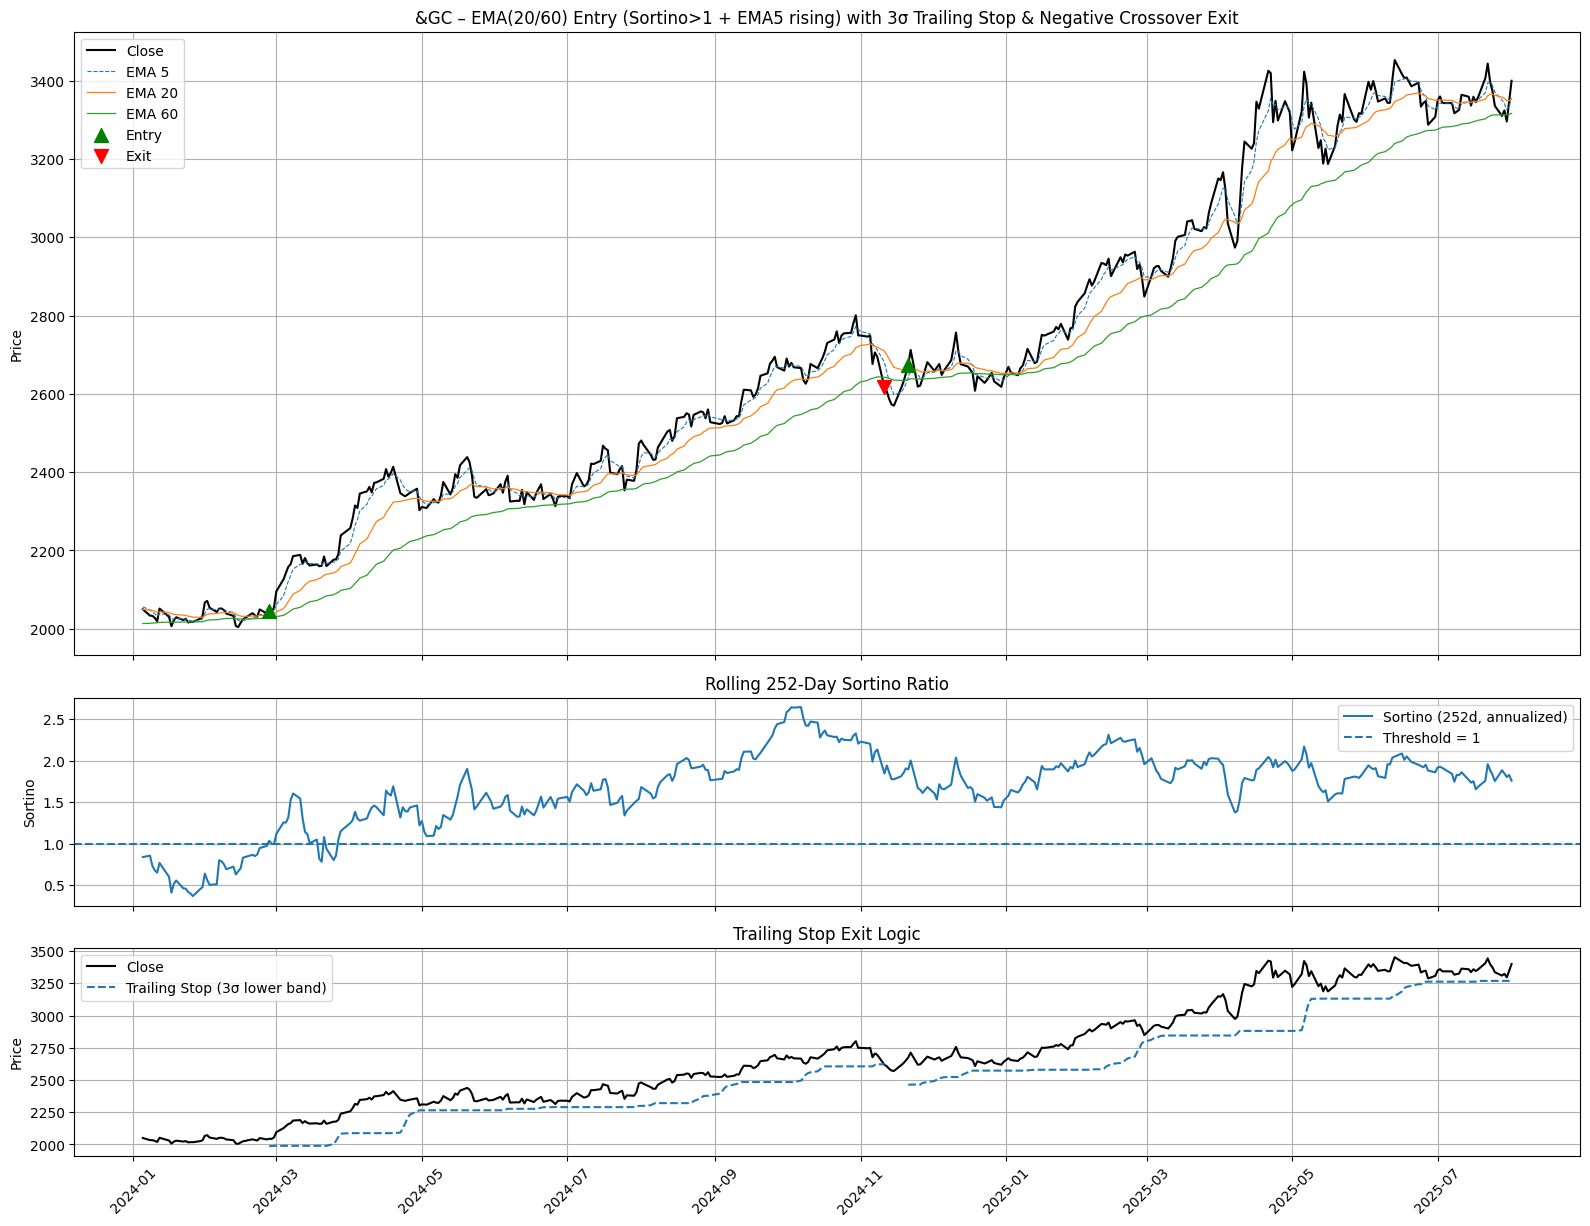

In [1]:
import norgatedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
symbol = '&GC'  # Gold futures continuous (Norgate)
start_date = '2023-01-01'
end_date = '2025-08-01'
rolling_window = 252  # Sortino lookback

# Fetch data
df = norgatedata.price_timeseries(
    symbol,
    start_date=start_date,
    end_date=end_date,
    format='pandas-dataframe',
    stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
    padding_setting=norgatedata.PaddingType.NONE,
    timezone='UTC'
)

# Drop missing
df = df.dropna(subset=['Close']).copy()

# === Indicators ===
# EMAs
df['EMA_5']  = df['Close'].ewm(span=5,  adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_60'] = df['Close'].ewm(span=60, adjust=False).mean()

# Bollinger components for trailing stop (no upper band)
df['BB_MID'] = df['Close'].rolling(window=20).mean()
df['BB_STD'] = df['Close'].rolling(window=20).std()
df['BB_LOWER_3'] = df['BB_MID'] - 3 * df['BB_STD']

# Sortino (rolling, annualized, T=0)
returns = df['Close'].pct_change()

def calc_sortino(series, target=0.0):
    excess = series - target
    downside = excess[excess < 0]
    downside_dev = np.sqrt((downside**2).mean())
    mean_excess = excess.mean()
    if (downside_dev is not None) and (downside_dev > 0):
        return (mean_excess / downside_dev) * np.sqrt(252)
    return np.nan

df['Sortino'] = returns.rolling(window=rolling_window).apply(calc_sortino, raw=False)

# === Trade logic ===
df['Position'] = 0
df['Trailing_Stop'] = np.nan
df['Entry'] = False
df['Exit'] = False

in_trade = False
last_stop = np.nan

for i in range(len(df)):
    # Need at least 1 extra bar beyond warm-up for crossover slope checks
    if i < rolling_window + 1:
        continue

    row = df.iloc[i]
    prev = df.iloc[i-1]

    # Entry conditions: EMA(20) > EMA(60), all three EMAs rising, Sortino > 1
    ema5 = row['EMA_5'];   ema5_prev = prev['EMA_5']
    ema20 = row['EMA_20']; ema20_prev = prev['EMA_20']
    ema60 = row['EMA_60']; ema60_prev = prev['EMA_60']

    ema5_rising  = ema5  > ema5_prev
    ema20_rising = ema20 > ema20_prev
    ema60_rising = ema60 > ema60_prev
    sortino_ok   = row['Sortino'] > 1

    entry_signal = (
        (ema20 > ema60) and
        ema5_rising and
        ema20_rising and
        ema60_rising and
        sortino_ok
    )

    # Exit condition 1: negative crossover (20 crosses below 60)
    negative_cross = (ema20_prev >= ema60_prev) and (ema20 < ema60)

    if in_trade:
        # Update trailing stop (never decreases)
        current_stop = df['BB_LOWER_3'].iloc[i]
        last_stop = max(last_stop, current_stop)
        df.iloc[i, df.columns.get_loc('Trailing_Stop')] = last_stop

        # Exit on close below trailing stop OR negative crossover
        if (row['Close'] < last_stop) or negative_cross:
            in_trade = False
            last_stop = np.nan
            df.iloc[i, df.columns.get_loc('Exit')] = True

    else:
        if entry_signal:
            in_trade = True
            last_stop = row['BB_LOWER_3']
            df.iloc[i, df.columns.get_loc('Entry')] = True
            df.iloc[i, df.columns.get_loc('Trailing_Stop')] = last_stop

    df.iloc[i, df.columns.get_loc('Position')] = int(in_trade)

# === Plotting (start after warm-up) ===
df_plot = df.iloc[rolling_window+1:].copy()

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}
)

# Subplot 1: Price, EMAs, entries/exits
ax1.plot(df_plot.index, df_plot['Close'], label='Close', color='black')
ax1.plot(df_plot.index, df_plot['EMA_5'], label='EMA 5', linewidth=0.8, linestyle='--')
ax1.plot(df_plot.index, df_plot['EMA_20'], label='EMA 20', linewidth=0.9)
ax1.plot(df_plot.index, df_plot['EMA_60'], label='EMA 60', linewidth=0.9)
ax1.scatter(df_plot[df_plot['Entry']].index, df_plot[df_plot['Entry']]['Close'],
            color='green', marker='^', s=100, label='Entry', zorder=5)
ax1.scatter(df_plot[df_plot['Exit']].index, df_plot[df_plot['Exit']]['Close'],
            color='red', marker='v', s=100, label='Exit', zorder=5)
ax1.set_title(f'{symbol} – EMA(20/60) Entry (Sortino>1 + EMA5 rising) with 3σ Trailing Stop & Negative Crossover Exit')
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Subplot 2: Sortino (annualized)
ax2.plot(df_plot.index, df_plot['Sortino'], label='Sortino (252d, annualized)')
ax2.axhline(1, linestyle='--', label='Threshold = 1')
ax2.set_ylabel('Sortino')
ax2.set_title('Rolling 252-Day Sortino Ratio')
ax2.grid(True)
ax2.legend()

# Subplot 3: Trailing Stop
ax3.plot(df_plot.index, df_plot['Close'], label='Close', color='black')
ax3.plot(df_plot.index, df_plot['Trailing_Stop'], label='Trailing Stop (3σ lower band)',
         linestyle='--')
ax3.set_ylabel('Price')
ax3.set_title('Trailing Stop Exit Logic')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


_Figure 6 - Entry/Exit With EMA structure, BB and Sortino Filter_

### 7.7. Costs and Slippage
Zipline’s slippage/cost engine is used with a volume-aware model. We cap simulated participation at 20% of the day’s volume and scale price impact accordingly. Because orders are generated on daily bars and executed at the next session’s open (market-on-open logic), this provides a reasonable estimate of execution costs at daily frequency.

Transaction costs are modeled as a flat 0.85 USD per contract per side in brokerage commission and 1.50 USD per side in exchange/clearing fees (total ≈ 2.35 USD per side, 4.70 USD round trip). These settings are applied uniformly across contracts and are in line with what we’d expect from a broker such as Interactive Brokers.

Rolls use the same cost/slippage settings and are executed near the peak of front/next-month liquidity to avoid underestimating roll friction.

### 7.8. Interest on Liquidity
Futures require margin, so only 10–20% of equity is typically tied up; the remainder is idle cash unless invested. In live settings, managers commonly place excess collateral in short-dated government instruments (T-bills, government MMFs, or overnight repo) to earn interest while avoiding credit exposure. Holding collateral in T-bills rather than cash also reduces broker exposure, as idle balances at the broker are minimized.

Backtest assumption. The backtest does not accrue interest on idle cash. Unencumbered cash is assumed to earn 0% (and borrowing costs on negative balances are not modeled separately). This simplifies the simulation and keeps performance attributable to the trading strategy rather than cash yields.

### 7.9. Trend Model Source Code
From here, code is presented block-by-block with explanations, followed by a consolidated script.

This first block imports the core Zipline Reloaded API for futures trading—`future_symbol` and `continuous_future` for contract references; `schedule_function`, `date_rules`, and `time_rules` for daily logic; and `set_commission` / `set_slippage` for execution cost modeling. It also brings in the commission and slippage models we will configure later (`PerContract`, `VolumeShareSlippage`, etc.).

Supporting libraries are imported for analysis and reporting: pandas, numpy, matplotlib, and pyfolio (for post-run performance analysis). The `%matplotlib inline` directive enables inline plotting in notebooks. The small widgets snippet prepares an HTML output cell for simple runtime status messages.

Finally, the block imports Norgate Data and the helper `register_norgatedata_futures_bundle`. (This block only imports the function; the actual bundle registration is typically done in `~/.zipline/extension.py` or in a separate setup cell as we shown in point three.) Norgate provides contract metadata (expiries, multipliers, auto-close dates) and daily OHLCV needed for continuous and discrete futures handling.


In [ ]:
%matplotlib inline

import zipline
from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target, symbol, set_benchmark
from pandas import Timestamp
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, \
    FixedSlippage, VolatilityVolumeShare
import sys
from pprint import pprint,pformat
import json
import norgatedata

# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

from zipline_norgatedata import register_norgatedata_futures_bundle


We specify a broad universe of futures root symbols spanning currencies, commodities (agriculture, energy, metals), interest rates, and equity indices. The strategy is intended to run portfolio-wide to capture trends wherever they appear, rather than concentrating on a single asset class.

Initial capital is set to $10,000,000. Position size is determined by an equal risk per market rule: each trade targets 0.5% of equity (`risk_factor = 0.005`) using recent realized volatility over a 20-day window (`vola_window = 20`). Volatility is measured in dollar terms, aligning sizing with the instrument’s typical daily move. This is consistent with the 3σ trailing-stop framework used for exits.

To avoid illiquid markets on daily data, a liquidity filter excludes instruments whose 5-day average volume falls below the threshold set by `min_avg_vol`. In the current configuration, min_avg_vol = 100 contracts.

Execution costs are enabled via `enable_commission = True` and `enable_slippage = True` so that commissions and slippage modeled later are applied to all orders. This setup reflects realistic constraints without over-engineering the pre-trade filters.

In [ ]:
"""
Model Settings
"""
# ASSETS TO TRADE IN PORTFOLIO:
SELECTED_SYMBOLS = [
        # Currency
        'BTC', # Bitcoin  
        'DX', # US Dollar Index  
        'ETH', # Ether 
        

        # Agriculture & Livestock
        'CC', # Cocoa 
        'CT', # Cotton No. 2 
        'DC', # Class III Milk 
        'GF', # Feeder Cattle 
        'HE', # Lean Hogs 
        'KC', # Coffee C 
        'LBR', # Lumber 
        'LE', # Live Cattle 
        'LSU', # White Sugar 
        'OJ', # Orange Juice OJ 
        'RS', # Canola 
        'SB', # Sugar No. 11 
        'ZC', # Corn 
        'ZL', # Soybean Oil 
        'ZM', # Soybean Meal 
        'ZO', # Oats 
        'ZR', # Rough Rice ZR 
        'ZS', # Soybeans 
        'ZW', # SRW Wheat 

        # Interest Rate
        'CGB', # Canada Bond 
        'FBTP', # Euro-BTP 
        'FGBL', # Euro-Bund 
        'FGBM', # Euro-Bobl 
        'FGBS', # Euro-Schatz 
        'FGBX', # Euro-Buxl 
        'FOAT', # Euro-OAT 
        'LLG', # Long Gilt 
        'SJB', # JGB Mini 
        'TN', # Ultra 10Y Note 
        'UB', # Ultra T-Bond 
        'YXT', # ASX 10Y Bond 
        'YYT', # ASX 3Y Bond 
        'ZB', # 30Y T-Bond 
        'ZF', # 5Y T-Note 
        'ZN', # 10Y T-Note 
        'ZT', # 2Y T-Note 

        # Stock Index
        'EMD', # E-mini MidCap 400
        'ES', # E-mini S&P 500
        'FCE', # CAC 40
        'FDAX', # DAX
        'FESX', # EURO STOXX 50
        'FSMI', # Swiss Market Index
        'FTDX', # TecDAX
        'HSI', # Hang Seng Index
        'HTW', # MSCI Taiwan
        'KOS', # KOSPI 200
        'LFT', # FTSE 100
        'NKD', # Nikkei 225 Dollar
        'NQ', # E-mini Nasdaq-100
        'RTY', # E-mini Russell 2000
        'SCN', # FTSE China A50
        'SSG', # MSCI Singapore
        'SXF', # S&P/TSX 60
        'YAP', # ASX SPI 200
        'YM', # E-mini Dow

        # Energy
        'BRN', # Brent Crude
        'CL', # Crude Oil
        'GAS', # Gas Oil
        'GWM', # UK Natural Gas
        'HO', # NY Harbor ULSD
        'NG', # Natural Gas
        'RB', # RBOB Gasoline
        'WBS', # WTI Crude

        # Metal
        'GC', # Gold
        'HG', # Copper
        'PA', # Palladium
        'PL', # Platinum
        'SI', # Silver
]
starting_portfolio = 10000000
risk_factor = 0.005 #RISK FACTOR: Fraction of capital risked per trade, drives position sizing and stop logic
vola_window = 20 #VOLA WINDOW: Loockback to calculate volatility, drives position sizing and stop logic
enable_commission = True
enable_slippage = True  

#LIQUIDITY FILTER: Only trade instruments whose 5-day average daily volume exceeds 100 contracts
min_avg_vol = 100
avg_vol_window = 5

With the universe and risk settings in place, the next component is a lightweight progress reporter that surfaces backtest status while the simulation runs.

This function updates a monthly counter, reads the current simulation date from `zipline.api.get_datetime()`, and computes an annualized return from inception using the portfolio value relative to the initial capital. The annualization assumes the function is called once per month, applying:

$$
\left( \frac{\text{PV}}{\text{starting\_portfolio}} \right)^{\frac{12}{\text{months}}} - 1
$$

The formatted message is written to the HTML widget (`out`), showing the date, total months elapsed, and current annualized performance—providing a simple running snapshot as the backtest progresses.

In [ ]:
def report_result(context, data): #Function used to update live HTML reporting 
    context.months += 1 #Keeps track of the number of months simulated
    today = zipline.api.get_datetime().date() #Retrives the current simulation date
    # Computes annualized return from the beginning of the backtest
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)

With progress reporting in place, the next operational piece is keeping positions in the liquid front month. The following function performs contract rollovers in a way that stays out of the core trading logic and avoids expiry risk.

This routine iterates over held futures, skips any with pending orders (to avoid conflicting instructions), and checks time-to-expiry using the contract’s `auto_close_date`. If there are 5 or fewer trading days remaining, it prepares a roll. The roll uses Zipline’s `continuous_future` with volume-based rollover and multiplicative price adjustment (`roll='volume'`, `adjustment='mul'`) to align with the continuation behavior described earlier and avoid artificial P&L jumps at the switch.

If the currently held contract is no longer the active one in the continuation, the function closes the expiring position and opens the same number of contracts in the new front month—preserving exposure on a contracts basis and maintaining continuity through the roll window.

In [ ]:
def roll_futures(context, data): #This function ensures that expiring futures positions are rolled into the next active contract, maintaining a continuous exposure
    open_orders = zipline.api.get_open_orders() #get a dictionary of all pending orders in the simulation, used to avoid duplicating actions for contracts already being traded in this bar
    
    for held_contract in context.portfolio.positions: #loop through currently held contracts
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: #if there's already an order in-flight, skip rolling to avoid conflict with your core trading logic
            continue
        
        # auto_close_date is when Zipline will forecefully close the position to simulate expiry, data.current_session gives the current trading date
        # compute how many days are left until forced close
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days

        #only roll contracts if they're 5 or fewer trading days from expiry, prevents unnecessary rolling
        if days_to_auto_close > 5:
            continue        
        
        # Make a continuation, get the current front-month continuous future
        #offset=0 use front contract
        #roll='volume' roll to next contract when volume surpasses current
        #adjustment='mul' price-adjust using multiplicative factor (prevents artificial PnL jumps on roll)
        continuation = continuous_future(
                held_contract.root_symbol, 
                offset=0, 
                roll='volume', 
                adjustment='mul'
                )
        
        # Pull the actual active futures contract from the continuation series
        continuation_contract = data.current(continuation, 'contract')
        
        if continuation_contract != held_contract:# If the current position is not in the new front contract, we need to roll it
            # Determine the number of contracts currently held in the expiring future
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            order_target(held_contract, 0)
            # Open the same position size in the new active contract
            order_target(continuation_contract, pos_size)    

With rollover mechanics defined, the next step is how many contracts to hold when a signal fires. The function below sizes positions so each trade targets the same dollar risk regardless of contract specs or asset class.

It takes three inputs:

- `portfolio_value` — current equity.

- `stop_distance` — the price distance to the stop (in price points, e.g., 3× a 20-day σ measured in points).

- `point_value` — dollars per full price point for the contract (e.g., ES: $50/point).

The target dollar risk per trade is `portfolio_value * risk_factor`. The expected dollar move of one contract to the stop is `stop_distance * point_value`. Dividing the former by the latter gives the number of contracts. The result is floored to an integer (futures are indivisible); invalid inputs (NaNs) yield zero to avoid accidental orders. This aligns with our equal risk per market approach and with the 3σ trailing-stop framework used in exits.

In [ ]:
def position_size(portfolio_value, stop_distance, point_value): #This function calculates how many contracts to buy or sell based on volatility targeting - a core principle in risk-parity and trend-following
    target_variation = portfolio_value * risk_factor #Dollar value of risk you are willing to take on this trade
    contract_variation = stop_distance * point_value #contract volatility in $ temrs:
    #std volatility estimate (eg 20day standard deviation of daily prices)
    #point_value the dollar value of 1 point of movment in the contract (ES futures, 1 point =$50)
    contracts = target_variation / contract_variation #divide dollar risk allowd  by risk per contract to get the number of contracts, ensures every trade contributes equally to total risk, adjusted for volatility
    return int(np.nan_to_num(contracts)) #Returns the integer number of contracts:
    #nan_to_num if input was invalid (NaN), it returns 0
    #int: no fractional contracts allowed in futures

With sizing defined, the next step is to configure the simulation: costs, tradable universe, and scheduled routines.

This initializer applies execution costs according to the flags. If commissions are enabled, a per-contract model is used (`PerContract(cost=0.85, exchange_fee=1.5`)). Slippage is modeled with a volume-aware function (`VolatilityVolumeShare`) capped at 20% participation. These settings are applied to futures via `set_commission` and `set_slippage`.

The tradable universe is then built by querying Zipline’s asset finder for all futures, filtering by the roots listed in `SELECTED_SYMBOLS`, and constructing front-month continuations for each (`offset=0`, `roll='volume'`, `adjustment='mul'`). This yields synthetic, roll-aware series for signal generation while execution remains on discrete contracts.

In [ ]:
def initialize(context):
    set_benchmark(symbol('$SPXTR'))    

    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)
    set_commission(us_futures=comm_model)

    if enable_slippage:
        slippage_model = VolatilityVolumeShare(volume_limit=0.2)
    else:
        slippage_model = FixedSlippage(spread=0.0)      
    set_slippage(us_futures=slippage_model) 

    """
    Markets to trade (filtered by SELECTED_SYMBOLS)
    """ 
    af = context.asset_finder
    allcontracts = af.retrieve_futures_contracts(af.futures_sids)

    markets = set()
    for contract in allcontracts.values():
        root = contract.root_symbol
        if root != '' and root in SELECTED_SYMBOLS:
            markets.add(root)

    markets = sorted(list(markets))

    context.universe = [
        continuous_future(m, offset=0, roll='volume', adjustment='mul')
        for m in markets
    ]

    context.highest_in_position = {m: 0 for m in markets}
    context.lowest_in_position = {m: 0 for m in markets}    

    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

    context.months = 0    

    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )


With the simulation configured and scheduled, the next component is post-run analysis and archiving.

This function runs after the backtest completes. It extracts the key artifacts from Zipline’s results—daily returns, positions, and transactions—via `pf.utils.extract_rets_pos_txn_from_zipline(perf)` and writes each to CSV. Filenames include the backtest start/end dates for traceability, and the output directory is created if it doesn’t exist.

For context, a benchmark series is also pulled from Norgate (`$SPXTR`, S&P 500 Total Return), restricted to the strategy’s date range and converted to daily percentage returns for comparison.

In [ ]:
def analyze(context, perf): #runs after the backtest completes and generates a performance tear sheet using Pyfolio, comparing the strategy to the benchamrk
    #extract the key outputs from the perf dictionary
    #returns: daily returns of your strategy
    #positions: holdings over time
    #transactions: trade-level execution data
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    # Save to CSV
    start_str = start_date.strftime("%Y-%m-%d")
    end_str = end_date.strftime("%Y-%m-%d")
    output_dir = r"C:\Users\Juanan\Downloads\CQF\1.Futures_Trend_Following\1.Zipline_Trades\1.Full_Backtest"
    os.makedirs(output_dir, exist_ok=True)

    
    returns_filename = os.path.join(output_dir, f"returns_{start_str}_to_{end_str}_TF.csv")
    positions_filename = os.path.join(output_dir, f"positions_{start_str}_to_{end_str}_TF.csv")
    transactions_filename = os.path.join(output_dir, f"transactions_{start_str}_to_{end_str}_TF.csv")
    returns.to_csv(returns_filename)
    positions.to_csv(positions_filename)
    transactions.to_csv(transactions_filename)
    
    #pulls benchmark data
    spxtr = norgatedata.price_timeseries(
        '$SPXTR',
        start_date = returns.index[0],
        end_date = returns.index[-1],
        format='pandas-dataframe',
        timezone='UTC',
    )
    #converts the benchmark price series into daily returns (percentage change) and drops first NaN
    spxtr_rets = spxtr['Close'].pct_change().dropna()
    spxtr_rets.name = '$SPXTR'
    
    # The following supresses all warnings - mainly because there is some code within pyfolio, 
    # empyrical, pandas and matplotlib that has deprecated calls - this just supresses the
    # warnings from showing
    import warnings
    warnings.filterwarnings('ignore')

    #standard institutional-level summary of strategy performance
    pf.create_returns_tear_sheet(returns, benchmark_rets=spxtr_rets)
    # Generate the full performance tear sheet
    #pf.create_full_tear_sheet(
        #returns=returns,
        #benchmark_rets=spxtr_rets,
        #positions=positions,
        #transactions=transactions,
        #round_trips=True
    #)

With post‐run analysis defined, the daily_trade routine is the workhorse that runs each market close to manage entries, exits, and rolls.

It first builds a 250-day history of close and volume for the entire continuation universe, computes the required indicators (EMA-5, EMA-20, EMA-60, their slopes, and the 20-day 3σ lower band used as the trailing stop anchor), and skips any instrument whose simulation clock is still before its listed `start_date`.

For open positions, the 3σ trailing stop is ratcheted: the stop is set to the maximum of its prior value and the latest 20-day lower band. An exit is triggered if either (i) the close is below the trailing stop, or (ii) a negative EMA crossover occurs (EMA-20 < EMA-60).

For new entries, the signal requires: EMA-20 > EMA-60 and both EMAs rising on the day. Sizing uses the volatility-based function: target dollar risk (`equity * risk_factor`) divided by stop distance (`close − bb_lower_20_3`) converted to dollars via the contract’s `price_multiplier`. The result is capped at 20% of the 20-day average volume and must also pass the liquidity filter (`avg_vol_window` rolling average vs `min_avg_vol`).

Two filters are applied before placing an order:

- Correlation filter: compute ~3-month (60-day) daily-return Pearson correlation between the candidate and each held continuation; if any correlation exceeds 0.9, the trade is skipped to avoid redundant exposure.

- Sortino filter: compute a 252-day rolling Sortino. Only instruments with Sortino > `SORTINO_THRESHOLD` (default 1.0) are eligible.

If both filters pass, the order is submitted and the trailing stop tracker is initialized. Finally, if there are open positions, the function calls the roll_futures helper to move expiring contracts into the front month when appropriate.

In [ ]:
def daily_trade(context, data):
    """
    Core daily logic:
      - Build history & indicators
      - Liquidity filter
      - Correlation filter vs existing positions
      - Sortino filter (downside deviation vs TARGET_RETURN)
      - Stop-distance-based sizing
      - Exits: (1) BB(20, 3σ) trailing stop, (2) EMA20 < EMA60 crossover
      - Contract roll handling
    """

    # ---- Config fallbacks (use globals if provided elsewhere) ----
    try:
        SORTINO_THRESHOLD
    except NameError:
        SORTINO_THRESHOLD = 1.0  # Require annualized Sortino > 1 by default
    try:
        ANNUALIZE_SORTINO
    except NameError:
        ANNUALIZE_SORTINO = True
    try:
        TARGET_RETURN
    except NameError:
        TARGET_RETURN = 0.0      # Daily MAR / risk-free in decimal terms

    # ---- Pull history for all assets in one shot ----
    hist = data.history(
        context.universe,
        fields=['close', 'volume'],
        frequency='1d',
        bar_count=250,
    )

    # Liquidity feature: rolling avg volume
    hist['avg_vol'] = hist['volume'].rolling(avg_vol_window).mean()

    # Map of currently open positions by root symbol
    open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions}

    for continuation in context.universe:

        # Skip before instrument start
        if context.datetime.tz_localize(None) < continuation.start_date:
            continue

        root = continuation.root_symbol
        h = hist.xs(continuation, level=1)

        # ---- Indicators ----
        h['ema_5']   = h['close'].ewm(span=5).mean()
        #h['ema_10']  = h['close'].ewm(span=10).mean()
        h['ema_20']  = h['close'].ewm(span=20).mean()
        h['ema_60']  = h['close'].ewm(span=60).mean()
        #h['ema_100'] = h['close'].ewm(span=100).mean()
        #h['ema_200'] = h['close'].ewm(span=200).mean()

        h['ema_5_rising']   = h['ema_5'].diff() > 0
        #h['ema_10_rising']  = h['ema_10'].diff() > 0
        h['ema_20_rising']  = h['ema_20'].diff() > 0
        h['ema_60_rising']  = h['ema_60'].diff() > 0
        #h['ema_100_rising'] = h['ema_100'].diff() > 0
        #h['ema_200_rising'] = h['ema_200'].diff() > 0

        # Bands & trailing stop anchor
        h['bb_lower_20_3'] = h['close'].rolling(20).mean() - 3 * h['close'].rolling(20).std()

        # ==== If we have a position: manage exits ====
        if root in open_pos:
            contract = open_pos[root]

            # Initialize or ratchet the trailing stop (max of prior stop and latest BB lower)
            if context.lowest_in_position[root] == 0:
                context.lowest_in_position[root] = h['bb_lower_20_3'].iloc[-1]
            else:
                context.lowest_in_position[root] = max(
                    context.lowest_in_position[root],
                    h['bb_lower_20_3'].iloc[-1]
                )

            trailing_stop = context.lowest_in_position[root]

            # --- Exit Rule 1: BB(20,3σ) trailing stop breach ---
            bb_stop_trigger = h['close'].iloc[-1] < trailing_stop

            # --- Exit Rule 2: EMA 20/60 bearish crossover ---
            ema_crossover_trigger = h['ema_20'].iloc[-1] < h['ema_60'].iloc[-1]

            if bb_stop_trigger or ema_crossover_trigger:
                order_target(contract, 0)
                context.lowest_in_position[root] = 0  # reset on exit

        # ==== No position: evaluate entry ====
        else:
            # Trend/rising EMAs & structure filter
            entry_signal = (
                h['ema_5_rising'].iloc[-1] and
                #h['ema_10_rising'].iloc[-1] and
                h['ema_20_rising'].iloc[-1] and
                h['ema_60_rising'].iloc[-1] and
                #h['ema_100_rising'].iloc[-1] and
                #h['ema_200_rising'].iloc[-1] and
                (h['ema_20'].iloc[-1] > h['ema_60'].iloc[-1])
            )

            if not entry_signal:
                continue

            # Determine active contract
            contract = data.current(continuation, 'contract')
            if contract is None:
                continue

            # Stop distance sizing (avoid non-positive distances)
            stop_distance = h['close'].iloc[-1] - h['bb_lower_20_3'].iloc[-1]
            if stop_distance <= 0 or np.isnan(stop_distance):
                continue

            # Base position size from risk
            contracts_to_trade = position_size(
                context.portfolio.portfolio_value,
                stop_distance,
                contract.price_multiplier
            )

            # Cap by recent volume participation (20% of 20-day avg volume)
            vol20 = h['volume'][-20:].mean()
            contracts_cap = int(vol20 * 0.2) if vol20 == vol20 else 0
            contracts_to_trade = max(0, min(contracts_to_trade, contracts_cap))

            # Liquidity filter
            if h['avg_vol'].iloc[-1] < min_avg_vol or contracts_to_trade <= 0:
                continue

            # ---- Correlation filter vs existing holdings ----
            corr_window = 60
            eligible_to_trade = True
            try:
                new_close = data.history(continuation, fields='close', bar_count=corr_window, frequency='1d')
                new_returns = new_close.pct_change().dropna()
            except Exception:
                eligible_to_trade = False

            if eligible_to_trade and len(open_pos) > 0:
                for held_symbol, held_contract in open_pos.items():
                    held_continuation = continuous_future(held_symbol, offset=0, roll='volume', adjustment='mul')
                    try:
                        held_close = data.history(held_continuation, fields='close', bar_count=corr_window, frequency='1d')
                        held_returns = held_close.pct_change().dropna()
                    except Exception:
                        continue

                    # Align lengths
                    min_len = min(len(held_returns), len(new_returns))
                    if min_len < 5:
                        continue

                    corr = np.corrcoef(new_returns[-min_len:], held_returns[-min_len:])[0, 1]
                    if corr > 0.9:
                        eligible_to_trade = False
                        break

            if not eligible_to_trade:
                continue

            # ---- Sortino filter (correct downside deviation vs TARGET_RETURN) ----
            try:
                sortino_window = 252
                sortino_close = data.history(continuation, fields='close', bar_count=sortino_window, frequency='1d')
                rets = sortino_close.pct_change().dropna()

                # Excess returns vs target
                excess = rets - TARGET_RETURN

                # Downside deviation: RMS of negative excess (relative to target)
                downside = np.minimum(excess, 0.0)
                downside_dev = np.sqrt((downside ** 2).mean())

                if downside_dev == 0 or np.isnan(downside_dev):
                    sortino = -np.inf
                else:
                    sortino = excess.mean() / downside_dev
                    if ANNUALIZE_SORTINO:
                        sortino *= np.sqrt(252)

                if sortino > SORTINO_THRESHOLD:
                    order_target(contract, contracts_to_trade)
                    context.lowest_in_position[root] = h['bb_lower_20_3'].iloc[-1]

            except Exception:
                # Silently skip if we can’t compute a robust Sortino for this asset today
                pass

    # ==== Handle rolls for any open positions ====
    if len(open_pos) > 0:
        roll_futures(context, data)

With the daily logic in place, the final step is to run the simulation over the full sample.

This block anchors the backtest with a long history by fixing `start_date` to 2001-12-28 and sets an explicit `end_date` (UTC) to align with Norgate’s bar timestamps. Zipline then executes the strategy at daily frequency using the `norgatedata-full-futures` bundle. The trading rules are wired through `initialize`, and post-run reporting is handled by `analyze`. We pass `benchmark_returns=None` here because the S&P 500 Total Return series is loaded and compared inside the analysis step. Library warnings are suppressed to keep the output readable.

In [ ]:
# Start date fixed as historical anchor
start_date = Timestamp('2001-12-28')
# End date = today (previous trading day in UTC to match Norgate bars)
end_date = Timestamp('2025-08-12')


# Turn off all warnings to make the output a little nicer:
import warnings
warnings.filterwarnings("ignore")

perf = zipline.run_algorithm(
    start=start_date, end=end_date, 
    initialize=initialize, 
    #before_trading_start=before_trading_start,
    analyze=analyze,
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='norgatedata-full-futures',
    benchmark_returns=None,
) 

With all components validated in isolation, the script below stitches them together end-to-end. It includes: model settings (universe, risk, liquidity), lightweight progress reporting, rollover handling, volatility-based sizing, the `initialize` wiring (costs, continuations, schedules), post-run analysis/archiving, the daily trading loop (signals, filters, sizing, exits, rolls), and the final `run_algorithm` call.

All logic is explicit so each parameter can be inspected or swapped without affecting the rest.

In [ ]:
%matplotlib inline
import os
import zipline
from zipline.api import future_symbol,  \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target, symbol, set_benchmark
from pandas import Timestamp
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, \
    FixedSlippage, VolatilityVolumeShare
import sys
from pprint import pprint,pformat
import json
import norgatedata

# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

from zipline_norgatedata import register_norgatedata_futures_bundle


"""
Model Settings
"""
# ASSETS TO TRADE IN PORTFOLIO:
SELECTED_SYMBOLS = [
        # Currency
        'BTC', # Bitcoin OK 
        'DX', # US Dollar Index OK 
        'ETH', # Ether OK
        

        # Agriculture & Livestock
        'CC', # Cocoa OK
        'CT', # Cotton No. 2 OK
        'DC', # Class III Milk OK
        'GF', # Feeder Cattle OK
        'HE', # Lean Hogs OK
        'KC', # Coffee C OK
        'LBR', # Lumber OK
        'LE', # Live Cattle OK
        'LSU', # White Sugar OK
        'OJ', # Orange Juice OJ OK
        'RS', # Canola OK
        'SB', # Sugar No. 11 OK
        'ZC', # Corn OK
        'ZL', # Soybean Oil OK
        'ZM', # Soybean Meal OK
        'ZO', # Oats OK
        'ZR', # Rough Rice ZR OK
        'ZS', # Soybeans OK
        'ZW', # SRW Wheat OK

        # Interest Rate
        'CGB', # Canada Bond OK
        'FBTP', # Euro-BTP OK 
        'FGBL', # Euro-Bund OK
        'FGBM', # Euro-Bobl OK
        'FGBS', # Euro-Schatz OK
        'FGBX', # Euro-Buxl OK 
        'FOAT', # Euro-OAT OK
        'LLG', # Long Gilt OK
        'SJB', # JGB Mini OK
        'TN', # Ultra 10Y Note OK
        'UB', # Ultra T-Bond OK
        'YXT', # ASX 10Y Bond OK 
        'YYT', # ASX 3Y Bond OK
        'ZB', # 30Y T-Bond OK
        'ZF', # 5Y T-Note OK
        'ZN', # 10Y T-Note OK
        'ZT', # 2Y T-Note OK

        # Stock Index
        'EMD', # E-mini MidCap 400
        'ES', # E-mini S&P 500
        'FCE', # CAC 40
        'FDAX', # DAX
        'FESX', # EURO STOXX 50
        'FSMI', # Swiss Market Index
        'FTDX', # TecDAX
        'HSI', # Hang Seng Index
        'HTW', # MSCI Taiwan
        'KOS', # KOSPI 200
        'LFT', # FTSE 100
        'NKD', # Nikkei 225 Dollar
        'NQ', # E-mini Nasdaq-100
        'RTY', # E-mini Russell 2000
        'SCN', # FTSE China A50
        'SSG', # MSCI Singapore
        'SXF', # S&P/TSX 60
        'YAP', # ASX SPI 200
        'YM', # E-mini Dow

        # Energy
        'BRN', # Brent Crude
        'CL', # Crude Oil
        'GAS', # Gas Oil
        'GWM', # UK Natural Gas
        'HO', # NY Harbor ULSD
        'NG', # Natural Gas
        'RB', # RBOB Gasoline
        'WBS', # WTI Crude

        # Metal
        'GC', # Gold
        'HG', # Copper
        'PA', # Palladium
        'PL', # Platinum
        'SI', # Silver
]
starting_portfolio = 10000000
risk_factor = 0.005 #RISK FACTOR: Fraction of capital risked per trade, drives position sizing and stop logic
vola_window = 20 #VOLA WINDOW: Loockback to calculate volatility, drives position sizing and stop logic
enable_commission = True
enable_slippage = True  

#LIQUIDITY FILTER: Only trade instruments whose 5-day average daily volume exceeds 100 contracts
min_avg_vol = 100 
avg_vol_window = 5


def report_result(context, data): #Function used to update live HTML reporting 
    context.months += 1 #Keeps track of the number of months simulated
    today = zipline.api.get_datetime().date() #Retrives the current simulation date
    # Computes annualized return from the beginning of the backtest
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)

def roll_futures(context, data): #This function ensures that expiring futures positions are rolled into the next active contract, maintaining a continuous exposure
    open_orders = zipline.api.get_open_orders() #get a dictionary of all pending orders in the simulation, used to avoid duplicating actions for contracts already being traded in this bar
    
    for held_contract in context.portfolio.positions: #loop through currently held contracts
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: #if there's already an order in-flight, skip rolling to avoid conflict with your core trading logic
            continue
        
        # auto_close_date is when Zipline will forecefully close the position to simulate expiry, data.current_session gives the current trading date
        # compute how many days are left until forced close
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days

        #only roll contracts if they're 5 or fewer trading days from expiry, prevents unnecessary rolling
        if days_to_auto_close > 5:
            continue        
        
        # Make a continuation, get the current front-month continuous future
        #offset=0 use front contract
        #roll='volume' roll to next contract when volume surpasses current
        #adjustment='mul' price-adjust using multiplicative factor (prevents artificial PnL jumps on roll)
        continuation = continuous_future(
                held_contract.root_symbol, 
                offset=0, 
                roll='volume', 
                adjustment='mul'
                )
        
        # Pull the actual active futures contract from the continuation series
        continuation_contract = data.current(continuation, 'contract')
        
        if continuation_contract != held_contract:# If the current position is not in the new front contract, we need to roll it
            # Determine the number of contracts currently held in the expiring future
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            order_target(held_contract, 0)
            # Open the same position size in the new active contract
            order_target(continuation_contract, pos_size)     
            
def position_size(portfolio_value, stop_distance, point_value): #This function calculates how many contracts to buy or sell based on volatility targeting - a core principle in risk-parity and trend-following
    target_variation = portfolio_value * risk_factor #Dollar value of risk you are willing to take on this trade
    contract_variation = stop_distance * point_value #contract volatility in $ temrs:
    #std volatility estimate (eg 20day standard deviation of daily prices)
    #point_value the dollar value of 1 point of movment in the contract (ES futures, 1 point =$50)
    contracts = target_variation / contract_variation #divide dollar risk allowd  by risk per contract to get the number of contracts, ensures every trade contributes equally to total risk, adjusted for volatility
    return int(np.nan_to_num(contracts)) #Returns the integer number of contracts:
    #nan_to_num if input was invalid (NaN), it returns 0
    #int: no fractional contracts allowed in futures

def initialize(context):
    set_benchmark(symbol('$SPXTR'))    

    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)
    set_commission(us_futures=comm_model)

    if enable_slippage:
        slippage_model = VolatilityVolumeShare(volume_limit=0.2)
    else:
        slippage_model = FixedSlippage(spread=0.0)      
    set_slippage(us_futures=slippage_model) 

    """
    Markets to trade (filtered by SELECTED_SYMBOLS)
    """ 
    af = context.asset_finder
    allcontracts = af.retrieve_futures_contracts(af.futures_sids)

    markets = set()
    for contract in allcontracts.values():
        root = contract.root_symbol
        if root != '' and root in SELECTED_SYMBOLS:
            markets.add(root)

    markets = sorted(list(markets))

    context.universe = [
        continuous_future(m, offset=0, roll='volume', adjustment='mul')
        for m in markets
    ]

    context.highest_in_position = {m: 0 for m in markets}
    context.lowest_in_position = {m: 0 for m in markets}    

    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

    context.months = 0    

    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

    
def analyze(context, perf): #runs after the backtest completes and generates a performance tear sheet using Pyfolio, comparing the strategy to the benchamrk
    #extract the key outputs from the perf dictionary
    #returns: daily returns of your strategy
    #positions: holdings over time
    #transactions: trade-level execution data
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    # Save to CSV
    start_str = start_date.strftime("%Y-%m-%d")
    end_str = end_date.strftime("%Y-%m-%d")
    output_dir = r"C:\Users\Juanan\Downloads\CQF\1.Futures_Trend_Following\1.Zipline_Trades\1.Full_Backtest"
    os.makedirs(output_dir, exist_ok=True)

    
    returns_filename = os.path.join(output_dir, f"returns_{start_str}_to_{end_str}_TF.csv")
    positions_filename = os.path.join(output_dir, f"positions_{start_str}_to_{end_str}_TF.csv")
    transactions_filename = os.path.join(output_dir, f"transactions_{start_str}_to_{end_str}_TF.csv")
    returns.to_csv(returns_filename)
    positions.to_csv(positions_filename)
    transactions.to_csv(transactions_filename)
    
    #pulls benchmark data
    spxtr = norgatedata.price_timeseries(
        '$SPXTR',
        start_date = returns.index[0],
        end_date = returns.index[-1],
        format='pandas-dataframe',
        timezone='UTC',
    )
    #converts the benchmark price series into daily returns (percentage change) and drops first NaN
    spxtr_rets = spxtr['Close'].pct_change().dropna()
    spxtr_rets.name = '$SPXTR'
    
    # The following supresses all warnings - mainly because there is some code within pyfolio, 
    # empyrical, pandas and matplotlib that has deprecated calls - this just supresses the
    # warnings from showing
    import warnings
    warnings.filterwarnings('ignore')

    #standard institutional-level summary of strategy performance
    pf.create_returns_tear_sheet(returns, benchmark_rets=spxtr_rets)
    # Generate the full performance tear sheet
    #pf.create_full_tear_sheet(
        #returns=returns,
        #benchmark_rets=spxtr_rets,
        #positions=positions,
        #transactions=transactions,
        #round_trips=True
    #)
    
def daily_trade(context, data):
    """
    Core daily logic:
      - Build history & indicators
      - Liquidity filter
      - Correlation filter vs existing positions
      - Sortino filter (downside deviation vs TARGET_RETURN)
      - Stop-distance-based sizing
      - Exits: (1) BB(20, 3σ) trailing stop, (2) EMA20 < EMA60 crossover
      - Contract roll handling
    """

    # ---- Config fallbacks (use globals if provided elsewhere) ----
    try:
        SORTINO_THRESHOLD
    except NameError:
        SORTINO_THRESHOLD = 1.0  # Require annualized Sortino > 1 by default
    try:
        ANNUALIZE_SORTINO
    except NameError:
        ANNUALIZE_SORTINO = True
    try:
        TARGET_RETURN
    except NameError:
        TARGET_RETURN = 0.0      # Daily MAR / risk-free in decimal terms

    # ---- Pull history for all assets in one shot ----
    hist = data.history(
        context.universe,
        fields=['close', 'volume'],
        frequency='1d',
        bar_count=250,
    )

    # Liquidity feature: rolling avg volume
    hist['avg_vol'] = hist['volume'].rolling(avg_vol_window).mean()

    # Map of currently open positions by root symbol
    open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions}

    for continuation in context.universe:

        # Skip before instrument start
        if context.datetime.tz_localize(None) < continuation.start_date:
            continue

        root = continuation.root_symbol
        h = hist.xs(continuation, level=1)

        # ---- Indicators ----
        h['ema_5']   = h['close'].ewm(span=5).mean()
        #h['ema_10']  = h['close'].ewm(span=10).mean()
        h['ema_20']  = h['close'].ewm(span=20).mean()
        h['ema_60']  = h['close'].ewm(span=60).mean()
        #h['ema_100'] = h['close'].ewm(span=100).mean()
        #h['ema_200'] = h['close'].ewm(span=200).mean()

        h['ema_5_rising']   = h['ema_5'].diff() > 0
        #h['ema_10_rising']  = h['ema_10'].diff() > 0
        h['ema_20_rising']  = h['ema_20'].diff() > 0
        h['ema_60_rising']  = h['ema_60'].diff() > 0
        #h['ema_100_rising'] = h['ema_100'].diff() > 0
        #h['ema_200_rising'] = h['ema_200'].diff() > 0

        # Bands & trailing stop anchor
        h['bb_lower_20_3'] = h['close'].rolling(20).mean() - 3 * h['close'].rolling(20).std()

        # ==== If we have a position: manage exits ====
        if root in open_pos:
            contract = open_pos[root]

            # Initialize or ratchet the trailing stop (max of prior stop and latest BB lower)
            if context.lowest_in_position[root] == 0:
                context.lowest_in_position[root] = h['bb_lower_20_3'].iloc[-1]
            else:
                context.lowest_in_position[root] = max(
                    context.lowest_in_position[root],
                    h['bb_lower_20_3'].iloc[-1]
                )

            trailing_stop = context.lowest_in_position[root]

            # --- Exit Rule 1: BB(20,3σ) trailing stop breach ---
            bb_stop_trigger = h['close'].iloc[-1] < trailing_stop

            # --- Exit Rule 2: EMA 20/60 bearish crossover ---
            ema_crossover_trigger = h['ema_20'].iloc[-1] < h['ema_60'].iloc[-1]

            if bb_stop_trigger or ema_crossover_trigger:
                order_target(contract, 0)
                context.lowest_in_position[root] = 0  # reset on exit

        # ==== No position: evaluate entry ====
        else:
            # Trend/rising EMAs & structure filter
            entry_signal = (
                h['ema_5_rising'].iloc[-1] and
                #h['ema_10_rising'].iloc[-1] and
                h['ema_20_rising'].iloc[-1] and
                h['ema_60_rising'].iloc[-1] and
                #h['ema_100_rising'].iloc[-1] and
                #h['ema_200_rising'].iloc[-1] and
                (h['ema_20'].iloc[-1] > h['ema_60'].iloc[-1])
            )

            if not entry_signal:
                continue

            # Determine active contract
            contract = data.current(continuation, 'contract')
            if contract is None:
                continue

            # Stop distance sizing (avoid non-positive distances)
            stop_distance = h['close'].iloc[-1] - h['bb_lower_20_3'].iloc[-1]
            if stop_distance <= 0 or np.isnan(stop_distance):
                continue

            # Base position size from risk
            contracts_to_trade = position_size(
                context.portfolio.portfolio_value,
                stop_distance,
                contract.price_multiplier
            )

            # Cap by recent volume participation (20% of 20-day avg volume)
            vol20 = h['volume'][-20:].mean()
            contracts_cap = int(vol20 * 0.2) if vol20 == vol20 else 0
            contracts_to_trade = max(0, min(contracts_to_trade, contracts_cap))

            # Liquidity filter
            if h['avg_vol'].iloc[-1] < min_avg_vol or contracts_to_trade <= 0:
                continue

            # ---- Correlation filter vs existing holdings ----
            corr_window = 60
            eligible_to_trade = True
            try:
                new_close = data.history(continuation, fields='close', bar_count=corr_window, frequency='1d')
                new_returns = new_close.pct_change().dropna()
            except Exception:
                eligible_to_trade = False

            if eligible_to_trade and len(open_pos) > 0:
                for held_symbol, held_contract in open_pos.items():
                    held_continuation = continuous_future(held_symbol, offset=0, roll='volume', adjustment='mul')
                    try:
                        held_close = data.history(held_continuation, fields='close', bar_count=corr_window, frequency='1d')
                        held_returns = held_close.pct_change().dropna()
                    except Exception:
                        continue

                    # Align lengths
                    min_len = min(len(held_returns), len(new_returns))
                    if min_len < 5:
                        continue

                    corr = np.corrcoef(new_returns[-min_len:], held_returns[-min_len:])[0, 1]
                    if corr > 0.9:
                        eligible_to_trade = False
                        break

            if not eligible_to_trade:
                continue

            # ---- Sortino filter (correct downside deviation vs TARGET_RETURN) ----
            try:
                sortino_window = 252
                sortino_close = data.history(continuation, fields='close', bar_count=sortino_window, frequency='1d')
                rets = sortino_close.pct_change().dropna()

                # Excess returns vs target
                excess = rets - TARGET_RETURN

                # Downside deviation: RMS of negative excess (relative to target)
                downside = np.minimum(excess, 0.0)
                downside_dev = np.sqrt((downside ** 2).mean())

                if downside_dev == 0 or np.isnan(downside_dev):
                    sortino = -np.inf
                else:
                    sortino = excess.mean() / downside_dev
                    if ANNUALIZE_SORTINO:
                        sortino *= np.sqrt(252)

                if sortino > SORTINO_THRESHOLD:
                    order_target(contract, contracts_to_trade)
                    context.lowest_in_position[root] = h['bb_lower_20_3'].iloc[-1]

            except Exception:
                # Silently skip if we can’t compute a robust Sortino for this asset today
                pass

    # ==== Handle rolls for any open positions ====
    if len(open_pos) > 0:
        roll_futures(context, data)





# Start date fixed as historical anchor
start_date = Timestamp('2001-12-28')
# End date = today (previous trading day in UTC to match Norgate bars)
end_date = Timestamp('2025-08-12')


# Turn off all warnings to make the output a little nicer:
import warnings
warnings.filterwarnings("ignore")

perf = zipline.run_algorithm(
    start=start_date, end=end_date, 
    initialize=initialize, 
    #before_trading_start=before_trading_start,
    analyze=analyze,
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='norgatedata-full-futures',
    benchmark_returns=None,
) 

Minor note on warnings: we may see messages like “Cannot place order … de-listed.” Those appear around expiry as contracts roll. They’re just expiry housekeeping—Zipline refusing to trade a contract we’ve already moved out of. Positions and P&L continue in the new front month, so results aren’t affected. If such messages ever show up well away from an expiry window, that would indicate a roll-timing issue; otherwise, we ignore them.

We’re intentionally not interpreting the metrics shown here (annual return, volatility, Sharpe, Calmar, max drawdown, Sortino, etc.). The right place to assess performance is after both models (trend and mean-reversion) are built and evaluated on the same assumptions, then combined and normalized at the portfolio level. Only then do Sharpe, drawdowns, tails, turnover and correlations mean what we need them to mean. Until that point, treat these numbers as diagnostics, not conclusions.

### 7.10. Core Trend Model Results
The table summarizes the model’s monthly and annual performance since 2001. The point is to assess whether the return stream behaves in line with what we expect from a trend-following system.

The model shows positive calendar-year returns in 21 out of 25 years. That’s solid. Most of the upside comes from prolonged directional moves — e.g., 2003, 2006, 2010, 2014, and 2019 — which is where trend systems tend to shine. Those years are up over +18% to +26%, and the gains are spread across multiple months, not concentrated in a single trade or market.

The system also has losing years, which is expected. Years like 2007, 2011, 2012 or 2018 show full-year drawdowns. These usually happen when markets are choppy or volatile but not directional, which tends to trigger repeated stop-outs. That’s not a failure — that’s the cost of doing business with reactive systems.

In [ ]:
# Required in Jupyter Notebooks
%matplotlib inline

# 1. Imports
import pandas as pd
import empyrical as em
from IPython.display import display, HTML

# 2. Load your returns CSV file
file_path = r"C:\Users\Juanan\Downloads\CQF\1.Futures_Trend_Following\1.Zipline_Trades\1.Full_Backtest\returns_2001-12-28_to_2025-08-12_TF.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# 3. Inspect available columns to confirm correct name
print("Columns found:", df.columns)

# 4. Replace 'returns' with your actual returns column name if different
returns_column = 'returns'  # <-- Change this if needed

# 5. Aggregate monthly and yearly returns using empyrical
monthly_data = em.aggregate_returns(df[returns_column], 'monthly')
yearly_data = em.aggregate_returns(df[returns_column], 'yearly')

# 6. Build the Monthly Returns Table in HTML
table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>
"""

first_year = True
first_month = True
yr = 0
mnth = 0

for m, val in monthly_data.items():
    yr = m[0]
    mnth = m[1]

    if first_month:
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False

    if first_year:
        first_year = False
        if mnth > 1:
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"

    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)

    if mnth == 12:
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
        table += "</tr>\n<tr>\n"
        first_month = True

# Final padding if last year doesn't end in December
if mnth != 12:
    for i in range(mnth + 1, 13):
        table += "<td align='right'>-</td>\n"
        if i == 12:
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
            table += "</tr>\n"

table += "</tbody></table>"

# 7. Display the table in notebook
display(HTML(table))


_Table 1 - Trend Following Monthly Returns_

Figure 6 shows the cumulative performance of the trend-following strategy alongside the S&P 500 Total Return Index. The model runs on a diversified futures portfolio, so the benchmark here isn’t a direct match. Still, the comparison gives useful context.

The main point of interest is the behavior during market stress. In both the 2008–2009 crisis and the early 2020 COVID selloff, the strategy held up well or even gained while equities dropped. That’s consistent with what a price-based trend system is designed to do: increase exposure during persistent directional moves, and cut losses quickly when trends break.

The second panel shows drawdowns. The benchmark suffers deeper and longer losses. The model’s drawdowns are generally smaller and shorter. This isn’t by accident — it's a result of both volatility filters and the ability to go flat. That dynamic risk control is more important than maximizing raw returns.

The third panel shows rolling 12-month correlation between the strategy and the S&P 500. It shifts across regimes, moving between weakly positive and near-zero, and occasionally negative. That variation is expected for a strategy that isn't tied to equity beta.

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import norgatedata

# --- Load Strategy Returns ---
returns_file_path = r"C:\Users\Juanan\Downloads\CQF\1.Futures_Trend_Following\1.Zipline_Trades\1.Full_Backtest\returns_2001-12-28_to_2025-08-12_TF.csv"
returns_df = pd.read_csv(returns_file_path, index_col=0, parse_dates=True)
returns_df.index = returns_df.index.tz_localize(None)  # Remove timezone info

# --- Load $SPXTR Total Return Index from NorgateData ---
symbol = "$SPXTR"
spxtr_df = norgatedata.price_timeseries(
    symbol,
    start_date="2001-12-28",
    end_date="2025-08-01",
    format="pandas-dataframe",
    stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
    padding_setting=norgatedata.PaddingType.NONE,
    timezone="UTC"
)

# Clean and process SPXTR data
if spxtr_df.empty:
    raise ValueError(f"No data found for {symbol}")
spxtr_df = spxtr_df.dropna(subset=["Close"])
spxtr_df.index = spxtr_df.index.tz_convert(None)

# --- Align Strategy and Benchmark by Date ---
combined_df = pd.DataFrame(index=returns_df.index)
combined_df["strategy_returns"] = returns_df["returns"]
combined_df["spxtr_returns"] = spxtr_df["Close"].pct_change()
combined_df.dropna(inplace=True)

# --- Compute Cumulative Returns ---
combined_df["strategy_cum"] = (1 + combined_df["strategy_returns"]).cumprod()
combined_df["spxtr_cum"] = (1 + combined_df["spxtr_returns"]).cumprod()

# --- Compute Drawdowns ---
running_max = combined_df["strategy_cum"].cummax()
combined_df["drawdown"] = combined_df["strategy_cum"] / running_max - 1

# --- Compute 12-Month Rolling Correlation (252 Trading Days) ---
combined_df["rolling_corr_12m"] = (
    combined_df["strategy_returns"]
    .rolling(window=252)
    .corr(combined_df["spxtr_returns"])
)

# --- Clean Data for Plotting ---
plot_df = combined_df.dropna(subset=["drawdown", "rolling_corr_12m"]).copy()
plot_df.index = pd.to_datetime(plot_df.index).tz_localize(None)

# Convert for plotting
x_vals = plot_df.index.to_numpy()
drawdown_vals = plot_df["drawdown"].astype(np.float64).to_numpy()
rolling_corr_vals = plot_df["rolling_corr_12m"].astype(np.float64).to_numpy()

# --- Plot ---
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True, constrained_layout=True)

# Cumulative Returns
axs[0].semilogy(x_vals, plot_df["strategy_cum"], label="Trend Following Strategy", color="black", linewidth=1.4)
axs[0].semilogy(x_vals, plot_df["spxtr_cum"], label="$SPXTR", color="gray", linewidth=1.2)
axs[0].legend(loc="upper left", frameon=True)
axs[0].set_ylabel("Cumulative Return (Log Scale)")
axs[0].set_title("Strategy Comparisons")

# Drawdown
axs[1].fill_between(x_vals, drawdown_vals, 0, color="black", alpha=0.9, label="Drawdown")
axs[1].legend(loc="lower left", frameon=True)
axs[1].set_ylabel("Drawdown")

# 12M Rolling Correlation
axs[2].fill_between(x_vals, rolling_corr_vals, 0, color="gray", alpha=0.8, label="12M Rolling Correlation")
axs[2].legend(loc="lower left", frameon=True)
axs[2].set_ylabel("Correlation")
axs[2].set_xlabel("Date")

plt.show()


_Figure 7 - Trend Following Model Equity Curve_

On the flip side, the model tends to underperform during extended bull markets with low volatility — like parts of 2017 and 2021. These are environments where trends are weak, compressed, or choppy. While this doesn’t violate the model’s logic, it can make performance look less compelling when compared directly to equities. That becomes a problem mostly in how the results are interpreted — especially by those anchored to long-only benchmarks.

From a portfolio construction view, the value is in what the model does when other assets are selling off. When most things are correlated and moving down together, this type of system often holds up — and that’s when diversification actually matters. We don't need outperformance all the time; we need it when nothing else is working.

The fact that the model has recently lagged isn't a reason to abandon it. Just like the sharp returns in 2008 weren’t repeatable year after year, short-term underperformance says more about the environment than the rules. The logic here is intentionally simple, but it’s shown it can survive real market cycles — and that counts more than optimization or curve-fitting.

In [ ]:
import empyrical as em
import seaborn as sns
import matplotlib.pyplot as plt

# Use the strategy returns from earlier
strategy_daily_returns = combined_df['strategy_returns']
strategy_yearly_returns = em.aggregate_returns(strategy_daily_returns, 'yearly')

# Convert to a list for easier indexing
yr_list = strategy_yearly_returns.tolist()
yr_index = strategy_yearly_returns.index

# Initialize the DataFrame to store holding period returns
num_years = len(yr_list)
holding_matrix = pd.DataFrame(index=yr_index, columns=range(1, num_years + 1))

# Populate the holding period map
for start_idx in range(num_years):
    for years_held in range(1, num_years - start_idx + 1):
        sub_returns = yr_list[start_idx:start_idx + years_held]
        ann_return = em.annual_return(pd.Series(sub_returns), period='yearly')
        holding_matrix.iat[start_idx, years_held - 1] = ann_return * 100  # convert to %

# Trim unused columns and rows (NaN)
holding_matrix = holding_matrix.dropna(how='all').dropna(axis=1, how='all').astype(float)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(holding_matrix, annot=True, fmt="+.0f", cmap="RdYlGn", center=0, cbar_kws={'label': 'Annualized Return (%)'})
plt.title("Strategy Annualized Return by Holding Period")
plt.xlabel("Years Held")
plt.ylabel("Starting Year")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


_Table 2 - Trend Following Holding Period Returns_

Table 2 shows how the strategy performs depending on when a trade is initiated and how long it’s held. The numbers represent annualized returns, assuming positions are held continuously over different forward horizons.

Most rows are stable after the 3- to 5-year mark, clustering between +6% and +9%. This consistency is encouraging. It means that even if short-term results vary, longer holding periods tend to average out noise and converge toward a more predictable range. That said, there are still some outliers.

In 2011, for instance, shows a poor start across the first couple of years, and while returns recover over time, they still underperform compared to other start years. In contrast, entries made in 2006, 2014, or 2019 show strong results even in the short run.

This tells us a few things. First, timing matters. There are years where the environment simply didn’t suit the model—whether due to trend failures, false breakouts, or tight ranges. Second, the model doesn’t rely on any one regime. The fact that multi-year returns stabilize regardless of entry point suggests the approach works across cycles.

This table doesn't show risk or drawdowns, so it's not a complete picture. But for understanding how the strategy behaves over time — particularly in terms of path dependence — it’s a useful tool. We get a sense of what to expect if we're holding for 1, 3, 5, or 10 years.